# Pointer Network - Convex Hull

This Jupyter Notebook outlines a solution to the planar convex hull problem by employing the pointer network architecture. We first generate a toy dataset consisting of 2D uniformly distributed points and convex hull indices by using `numpy`, `scipy`, and `shapely`. We then define a neural network architecture that generates input and target embeddings using a transformer encoder and decoder, respectively, followed by a pointer network to express a conditional probability over the input tokens. Lastly, we train the model and visualize a sample output.

For a high-level overview of this topic, refer to the Medium article [Pointer Networks with Transformers](https://medium.com/@masonmcgough/pointer-networks-with-transformers-1a01d83f7543).

In [2]:
import math
from pprint import pprint
from typing import Tuple, Union, Optional
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from shapely import geometry

%matplotlib inline

# Data

The following cells define PyTorch Datasets and DataLoaders to generate a dataset for the planar convex hull problem. We sort the random points in ascending lexicographic order (e.g. sort by ascending y coordinate followed by x) to maintain a consistent ordering of points. The targets are also sorted to be in counter-clockwise order starting with the first input coordinate.

In [3]:
def generate_random_points(
  n: int,
  sort_method: str = 'lex'
) -> np.ndarray:
  """
  Randomly sample n sorted uniformly distributed 2D points from [0.0, 1.0).

  Args:
    n: Number of x,y points to generate.
    sort_method: Method to sort points. The following methods are supported:
      lex: Sort in ascending lexicographic order starting from y.
      mag: Sort from least to greatest magnitude (or distance from origin).
  Outputs:
    Shape (n, 2) sorted numpy array of x,y coordinates.
  """

  points = np.random.random(size=[n, 2])
  if sort_method == 'lex':
    points = points[np.lexsort(([points[..., ax] for ax in range(points.shape[-1])]))]
  elif sort_method == 'mag':
    points = points[np.argsort(np.mean(points, axis=-1))]
  else:
    raise ValueError(f'{sort_method} is not a valid option for sort_method.')
  return points

def display_points(points: np.ndarray) -> None:
  """
  Display a set of 2D points on a scatterplot.

  Args:
    points: x,y coordinate points.
  """

  y_offset = 0.025
  plt.scatter(points[:, 0], points[:, 1])
  for i, point in enumerate(points):
    plt.text(point[0], point[1] + y_offset, str(i))
  plt.xlabel('x')
  plt.ylabel('y')
  plt.xlim(0., 1.)
  plt.ylim(0., 1.)
  plt.title(f'N: {len(points)}')
  plt.grid(True)

def display_points_with_hull(
  points: np.ndarray,
  hull: list
) -> None:
  """
  Display a set of 2D points with its convex hull.

  Args:
    points: x,y coordinate points.
    hull: List of indices indicating the convex hull of points.
  """

  display_points(points)
  for i in range(len(hull) - 1):
    p0 = hull[i]
    p1 = hull[i + 1]
    x = points[[p0, p1], 0]
    y = points[[p0, p1], 1]
    plt.plot(x, y, 'g')
    plt.arrow(x[0], y[0], (x[1] - x[0]) / 2., (y[1] - y[0]) / 2.,
              shape='full', lw=0, length_includes_head=True, head_width=.025,
              color='green')
  x = points[[p1, hull[0]], 0]
  y = points[[p1, hull[0]], 1]
  plt.arrow(x[0], y[0], (x[1] - x[0]) / 2., (y[1] - y[0]) / 2.,
            shape='full', lw=0, length_includes_head=True, head_width=.025,
            color='green')
  plt.plot(x, y, 'g')
  plt.grid(True)

def cyclic_permute(
  l: list,
  idx: int
) -> list:
  """
  Permute a list such that l[idx] becomes l[0] while preserving order.

  Args:
    l: List to permute.
    idx: Index to the element in l that should appear at position 0.
  Outputs:
    Cyclically permuted list of length len(l).
  """

  return l[idx:] + l[:idx]

Here we generate and visualize a single input-output pair. The arrows indicate the order of the convex hull points. Notice how the points of the convex hull always appear in counter-clockwise order.

[0, 1, 4, 5, 6, 2]


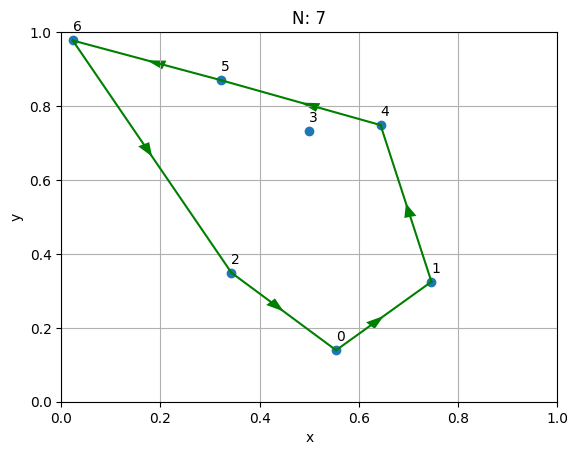

In [4]:
min_samples = 4
max_samples = 10

n_points = np.random.randint(low=min_samples, high=max_samples)
points = generate_random_points(n_points)
hull_sequence = ConvexHull(points).vertices.tolist()
hull_sequence = cyclic_permute(hull_sequence, np.argmin(hull_sequence))
display_points_with_hull(points, hull_sequence)
print(hull_sequence)

Here we construct a PyTorch Dataset using the code we just created. Inspired by the paper "[A Neural Representation of Sketch Drawings](https://arxiv.org/abs/1704.03477)" we define a 5-dimensional vector for each of our input points where the first two columns correspond to continuous x and y coordinate values, respectively, and the last three to a one-hot encoding of three possible states: starting token '<sos>', end-of-sequence token '<eos>', and padding. The one-hot encoding is not used for coordinate points.

In [5]:
import numpy as np

def read_coordinates_from_file(file_path):
    coordinates = []
    with open(file_path, "r") as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) == 2:
                try:
                    x = float(parts[0])
                    y = float(parts[1])
                except(ValueError):
                    continue
                coordinates.append((x, y))
    return coordinates

file_path_test_50 = r"tsp_unif_test50_100_100000.txt"
file_path_train_50 = r"tsp_unif50_10000_100000_1000.txt"
file_path_test_100 = r"tsp_unif_test100_100_100000.txt"
file_path_train_100 = r"tsp_unif100_10000_100000_1000.txt"

coordinates_test50 = read_coordinates_from_file(file_path_test_50)
test50 = np.array(coordinates_test50)
coordinates_train50 = read_coordinates_from_file(file_path_train_50)
train50 = np.array(coordinates_train50)

coordinates_test100 = read_coordinates_from_file(file_path_test_100)
test100 = np.array(coordinates_test100)

coordinates_train100 = read_coordinates_from_file(file_path_train_100)
train100 = np.array(coordinates_train100)

print(test50.shape, train50.shape, test100.shape, train100.shape)

testinstances50 = []
for i in range(0, 5000, 50):
    testinstances50.append(test50[i:i+50, :])
testinstances50 = np.array(testinstances50)
optimal_distances_test50 = []
for i in range(testinstances50.shape[0]):
    distance = 0
    for j in range(testinstances50.shape[1]-1):
        distance += np.linalg.norm(testinstances50[i][j] -  testinstances50[i][j+1])
    optimal_distances_test50.append(distance)
optimal_distances_test50 = np.array(optimal_distances_test50)

traininstances50 = []
for i in range(0, 1500000, 50):
    traininstances50.append(train50[i:i+50, :])
traininstances50 = np.array(traininstances50)
optimal_distances_train50 = []
for i in range(traininstances50.shape[0]):
    distance = 0
    for j in range(traininstances50.shape[1]-1):
        distance += np.linalg.norm(traininstances50[i][j] -  traininstances50[i][j+1])
    optimal_distances_train50.append(distance)
optimal_distances_train50 = np.array(optimal_distances_train50)
testinstances100 = []
for i in range(0, 10000, 100):
    testinstances100.append(test100[i:i+100, :])
testinstances100 = np.array(testinstances100)
optimal_distances_test100 = []
for i in range(testinstances100.shape[0]):
    distance = 0
    for j in range(testinstances100.shape[1]-1):
        distance += np.linalg.norm(testinstances100[i][j] -  testinstances100[i][j+1])
    optimal_distances_test100.append(distance)
optimal_distances_test100 = np.array(optimal_distances_test100)

traininstances100 = []
for i in range(0, 1000000, 100):
    traininstances100.append(train100[i:i+100, :])
traininstances100 = np.array(traininstances100)
optimal_distances_train100 = []
for i in range(traininstances100.shape[0]):
    distance = 0
    for j in range(traininstances100.shape[1]-1):
        distance += np.linalg.norm(traininstances100[i][j] -  traininstances100[i][j+1])
    optimal_distances_train100.append(distance)
optimal_distances_train100 = np.array(optimal_distances_train100)

(5000, 2) (1500000, 2) (10000, 2) (1000000, 2)


In [6]:
# TOKENS = {
#   '<sos>': 0,
#   '<eos>': 1
# }
TOKENS = {
  '<eos>': 0
}

class Scatter2DDataset(Dataset):
  def __init__(
    self,
    n_rows: int,
    min_samples: int,
    max_samples: int
  ):
    self.min_samples = min_samples
    self.max_samples = max_samples
    self.points = []
    self.targets = []
    n_points = np.random.randint(low=min_samples, high=max_samples + 1, size=n_rows)
    for c in n_points:
      points = generate_random_points(c)
      targets = ConvexHull(points).vertices.tolist()
      targets = cyclic_permute(targets, np.argmin(targets))
      self.points.append(points)
      self.targets.append(targets)

  def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
    points, targets, length = self.pad_item(self.points[idx], self.targets[idx])
    return points, targets, length

  def __len__(self) -> int:
    return len(self.points)

  def pad_item(
    self,
    points: list,
    targets: list
  ) -> Tuple[torch.tensor, torch.Tensor]:
    n_tokens = len(TOKENS)

    # points_padded = np.zeros((self.max_samples + n_tokens, 3 + n_tokens),
    points_padded = np.zeros((self.max_samples + n_tokens, 2 + n_tokens),
      dtype=np.float32)
    targets_padded = np.ones((self.max_samples), dtype=np.int64) \
      * TOKENS['<eos>']

    # points_padded[TOKENS['<sos>'], 2] = 1.0
    # points_padded[TOKENS['<eos>'], 3] = 1.0
    points_padded[TOKENS['<eos>'], 2] = 1.0
    points_padded[n_tokens:n_tokens + len(points), :2] = points
    # points_padded[n_tokens + len(points):, 4] = 1.0
    targets_padded[:len(targets)] = np.array([t + n_tokens for t in targets])

    points_padded = torch.tensor(points_padded, dtype=torch.float32)
    targets_padded = torch.tensor(targets_padded, dtype=torch.int64)
    length = torch.tensor(len(points) + 2, dtype=torch.int64)
    return points_padded, targets_padded, length

In [7]:
# TOKENS = {
#   '<sos>': 0,
#   '<eos>': 1
# }
TOKENS = {
  '<eos>': 0
}

class TSPDataset100():
    def __init__(self):
        self.max_samples = len(traininstances100)
        self.points = []
        self.targets = []
        for i in traininstances100:
            temp = np.random.permutation(len(i))
            self.targets.append(temp)
            self.points.append(i[temp])
            

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        points, targets, length = self.pad_item(self.points[idx], self.targets[idx])
        return points, targets, length

    def __len__(self) -> int:
        return len(self.points)
    
    def pad_item(
        self,
        points: list,
        targets: list
    ) -> Tuple[torch.tensor, torch.Tensor]:
        n_tokens = len(TOKENS)

    # points_padded = np.zeros((self.max_samples + n_tokens, 3 + n_tokens),
        points_padded = np.zeros((self.max_samples + n_tokens, 2 + n_tokens),
          dtype=np.float32)
        targets_padded = np.ones((self.max_samples), dtype=np.int64) \
          * TOKENS['<eos>']

    # points_padded[TOKENS['<sos>'], 2] = 1.0
    # points_padded[TOKENS['<eos>'], 3] = 1.0
        points_padded[TOKENS['<eos>'], 2] = 1.0
        points_padded[n_tokens:n_tokens + len(points), :2] = points
    # points_padded[n_tokens + len(points):, 4] = 1.0
        targets_padded[:len(targets)] = np.array([t + n_tokens for t in targets])

        points_padded = torch.tensor(points_padded, dtype=torch.float32)
        targets_padded = torch.tensor(targets_padded, dtype=torch.int64)
        length = torch.tensor(len(points) + 2, dtype=torch.int64)
        return points_padded, targets_padded, length

class TSPDatasetTest100():
    def __init__(self):
        self.max_samples = len(testinstances100)
        self.points = []
        self.targets = []
        for i in testinstances100:
            temp = np.random.permutation(len(i))
            self.targets.append(temp)
            self.points.append(i[temp])
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        points, targets, length = self.pad_item(self.points[idx], self.targets[idx])
        return points, targets, length

    def __len__(self) -> int:
        return len(self.points)
    
    def pad_item(
        self,
        points: list,
        targets: list
    ) -> Tuple[torch.tensor, torch.Tensor]:
        n_tokens = len(TOKENS)

    # points_padded = np.zeros((self.max_samples + n_tokens, 3 + n_tokens),
        points_padded = np.zeros((self.max_samples + n_tokens, 2 + n_tokens),
          dtype=np.float32)
        targets_padded = np.ones((self.max_samples), dtype=np.int64) \
          * TOKENS['<eos>']

    # points_padded[TOKENS['<sos>'], 2] = 1.0
    # points_padded[TOKENS['<eos>'], 3] = 1.0
        points_padded[TOKENS['<eos>'], 2] = 1.0
        points_padded[n_tokens:n_tokens + len(points), :2] = points
    # points_padded[n_tokens + len(points):, 4] = 1.0
        targets_padded[:len(targets)] = np.array([t + n_tokens for t in targets])

        points_padded = torch.tensor(points_padded, dtype=torch.float32)
        targets_padded = torch.tensor(targets_padded, dtype=torch.int64)
        length = torch.tensor(len(points) + 2, dtype=torch.int64)
        return points_padded, targets_padded, length

# Pointer Network Architecture

Here we define a series of functions that we will need to construct our architecture.

In [8]:
def info_value_of_dtype(dtype: torch.dtype):
  """
  Returns the `finfo` or `iinfo` object of a given PyTorch data type. Does not allow torch.bool.

  Adapted from allennlp by allenai:
    https://github.com/allenai/allennlp/blob/master/allennlp/nn/util.py
  """

  if dtype == torch.bool:
    raise TypeError("Does not support torch.bool")
  elif dtype.is_floating_point:
    return torch.finfo(dtype)
  else:
    return torch.iinfo(dtype)


def min_value_of_dtype(dtype: torch.dtype):
  """
  Returns the minimum value of a given PyTorch data type. Does not allow torch.bool.

  Adapted from allennlp by allenai:
    https://github.com/allenai/allennlp/blob/master/allennlp/nn/util.py
  """

  return info_value_of_dtype(dtype).min

def masked_log_softmax(
  x: torch.Tensor,
  mask: torch.Tensor,
  dim: int = -1,
  eps: float = 1e-45
) -> torch.Tensor:
  """
  Apply softmax to x with masking.

  Adapted from allennlp by allenai:
    https://github.com/allenai/allennlp/blob/master/allennlp/nn/util.py

  Args:
    x - Tensor of arbitrary shape to apply softmax over.
    mask - Binary mask of same shape as x where "False" indicates elements
      to disregard from operation.
    dim - Dimension over which to apply operation.
    eps - Stability constant for log operation. Added to mask to avoid NaN
      values in log.
  Outputs:
    Tensor with same dimensions as x.
  """

  x = x + (mask.float() + eps).log()
  return torch.nn.functional.log_softmax(x, dim=dim)

def masked_max(
  x: torch.Tensor,
	mask: torch.Tensor,
	dim: int,
	keepdim: bool = False
) -> Tuple[torch.Tensor, torch.Tensor]:
  """
  Apply max to x with masking.

  Adapted from allennlp by allenai:
    https://github.com/allenai/allennlp/blob/master/allennlp/nn/util.py

  Args:
    x - Tensor of arbitrary shape to apply max over.
    mask - Binary mask of same shape as x where "False" indicates elements
      to disregard from operation.
    dim - Dimension over which to apply operation.
    keepdim - If True, keeps dimension dim after operation.
  Outputs:
    A ``torch.Tensor`` of including the maximum values.
  """

  x_replaced = x.masked_fill(~mask, min_value_of_dtype(x.dtype))
  max_value, max_index = x_replaced.max(dim=dim, keepdim=keepdim)
  return max_value, max_index

def convert_binary_mask_to_infinity_mask(mask: torch.Tensor) -> torch.Tensor:
  """
  Convert the 0 and 1 elements in a binary mask to -inf and 0 for the
    transformer.

  Args:
    mask: Binary mask tensor.
  Outputs:
    Infinity mask tensor with same size as mask.
  """

  return mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

This is where we define the pointer network.

In [9]:
class PointerNetwork(nn.Module):
  """
  From "Pointer Networks" by Vinyals et al. (2017)

  Adapted from pointer-networks-pytorch by ast0414:
    https://github.com/ast0414/pointer-networks-pytorch

  Args:
    n_hidden: The number of features to expect in the inputs.
  """

  def __init__(
    self,
    n_hidden: int
  ):
    super().__init__()
    self.n_hidden = n_hidden
    self.w1 = nn.Linear(n_hidden, n_hidden, bias=False)
    self.w2 = nn.Linear(n_hidden, n_hidden, bias=False)
    self.v = nn.Linear(n_hidden, 1, bias=False)

  def forward(
    self,
    x_decoder: torch.Tensor,
    x_encoder: torch.Tensor,
    mask: torch.Tensor,
    eps: float = 1e-16
  ) -> torch.Tensor:
    """
    Args:
      x_decoder: Encoding over the output tokens.
      x_encoder: Encoding over the input tokens.
      mask: Binary mask over the softmax input.
    Shape:
      x_decoder: (B, Ne, C)
      x_encoder: (B, Nd, C)
      mask: (B, Nd, Ne)
    """

    # (B, Nd, Ne, C) <- (B, Ne, C)
    encoder_transform = self.w1(x_encoder).unsqueeze(1).expand(
      -1, x_decoder.shape[1], -1, -1)
    # (B, Nd, 1, C) <- (B, Nd, C)
    decoder_transform = self.w2(x_decoder).unsqueeze(2)
    # (B, Nd, Ne) <- (B, Nd, Ne, C), (B, Nd, 1, C)
    prod = self.v(torch.tanh(encoder_transform + decoder_transform)).squeeze(-1)
    # (B, Nd, Ne) <- (B, Nd, Ne)
    log_score = masked_log_softmax(prod, mask, dim=-1, eps=eps)
    return log_score


We now put all of those pieces together to create `ConvexNet`, our PyTorch module for modeling our planar convex hull data.

In [10]:
class ConvexNet(nn.Module):
  def __init__(
    self,
    c_inputs: int = 5,
    c_embed: int = 8,
    n_heads: int = 2,
    n_layers: int = 1,
    dropout: float = 0.1,
    c_hidden: int = 2
  ):
    super().__init__()
    self.c_hidden = c_hidden
    self.c_inputs = c_inputs
    self.c_embed = c_embed
    self.n_heads = n_heads
    self.n_layers = n_layers
    self.dropout = dropout

    self.embedding = nn.Linear(c_inputs, c_embed, bias=False)
    encoder_layers = nn.TransformerEncoderLayer(c_embed, n_heads, c_hidden, dropout)
    self.encoder = nn.TransformerEncoder(encoder_layers, n_layers)
    decoder_layers = nn.TransformerDecoderLayer(c_embed, n_heads, c_hidden, dropout)
    self.decoder = nn.TransformerDecoder(decoder_layers, n_layers)
    self.pointer = PointerNetwork(n_hidden=c_embed)

  def forward(
    self,
    batch_data: torch.Tensor,
    batch_lengths: torch.Tensor,
    batch_labels: Optional[torch.Tensor] = None
  ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    # assumes batch-first inputs
    batch_size = batch_data.shape[0]
    max_seq_len = batch_data.shape[1]
    c_embed = self.c_embed
    n_heads = self.n_heads

    x_embed = self.embedding(batch_data)
    encoder_outputs = self.encoder(x_embed.permute(1, 0, 2))

    # make mask
    range_tensor = torch.arange(max_seq_len, device=batch_lengths.device,
      dtype=batch_lengths.dtype).expand(batch_size, max_seq_len - len(TOKENS), max_seq_len)
    each_len_tensor = batch_lengths.view(-1, 1, 1).expand(-1, max_seq_len - len(TOKENS), max_seq_len)
    mask_tensor = (range_tensor < each_len_tensor)

    if batch_labels is not None:
      # teacher forcing
      # pass through decoder
      # here memory_mask is (batch_size * n_heads, len_decoder_seq, len_encoder_seq)
      # https://discuss.pytorch.org/t/memory-mask-in-nn-transformer/55230/5
      _bl = torch.cat((torch.zeros_like(batch_labels[:, :1]), batch_labels[:, :-1]), dim=1).permute(1, 0).unsqueeze(-1)
      _bl = _bl.expand(-1, batch_size, c_embed)
      decoder_input = torch.gather(encoder_outputs, dim=0, index=_bl)
      decoder_mask = mask_tensor.repeat((n_heads, 1, 1))
      dm = convert_binary_mask_to_infinity_mask(decoder_mask)
      tgt_mask = nn.Transformer.generate_square_subsequent_mask(len(decoder_input)).to(dm.device)
      decoder_outputs = self.decoder(decoder_input, encoder_outputs,
        tgt_mask=tgt_mask, memory_mask=dm)

      # pass through pointer network
      log_pointer_scores = self.pointer(
        decoder_outputs.permute(1, 0, 2),
        encoder_outputs.permute(1, 0, 2),
        mask_tensor)
      _, masked_argmaxs = masked_max(log_pointer_scores, mask_tensor, dim=-1)
      return log_pointer_scores, masked_argmaxs
    else:
      #
      log_pointer_scores = []
      masked_argmaxs = []
      decoder_input = encoder_outputs[:1]
      for _ in range(max_seq_len - len(TOKENS)):
        # pass through decoder network
        decoder_mask = mask_tensor[:, :len(decoder_input)].repeat((n_heads, 1, 1))
        dm = convert_binary_mask_to_infinity_mask(decoder_mask)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(len(decoder_input)).to(dm.device)
        decoder_outputs = self.decoder(decoder_input, encoder_outputs,
          tgt_mask=tgt_mask, memory_mask=dm)

        # pass through pointer network
        mask_subset = mask_tensor[:, :len(decoder_outputs)]
        log_pointer_score = self.pointer(
          decoder_outputs.permute(1, 0, 2),
          encoder_outputs.permute(1, 0, 2),
          mask_subset)
        _, masked_argmax = masked_max(log_pointer_score, mask_subset, dim=-1)

        # append new predictions
        log_pointer_scores.append(log_pointer_score[:, -1, :])
        new_maxes = masked_argmax[:, -1]
        masked_argmaxs.append(new_maxes)

        # mask out predicted inputs
        new_max_mask = torch.zeros((mask_tensor.shape[0], mask_tensor.shape[2]),
          dtype=torch.bool, device=mask_tensor.device)
        new_max_mask = new_max_mask.scatter(1, new_maxes.unsqueeze(1), True)
        new_max_mask[:, :2] = False
        new_max_mask = new_max_mask.unsqueeze(1).expand(-1, mask_tensor.shape[1], -1)
        mask_tensor[new_max_mask] = False

        # prepare inputs for next iteration
        next_indices = torch.stack(masked_argmaxs, dim=0).unsqueeze(-1).expand(-1, batch_size, c_embed)
        decoder_input = torch.cat((encoder_outputs[:1],
          torch.gather(encoder_outputs, dim=0, index=next_indices)), dim=0)
      log_pointer_scores = torch.stack(log_pointer_scores, dim=1)
      masked_argmaxs = torch.stack(masked_argmaxs, dim=1)
      return log_pointer_scores, masked_argmaxs

# Train

Now we prepare for training. We first construct a class to calculate and track the averages for an epoch.

In [11]:
class AverageMeter(object):
  """
  Computes and stores the average and current value

  Adapted from pointer-networks-pytorch by ast0414:
    https://github.com/ast0414/pointer-networks-pytorch
  """

  def __init__(self):
    self.history = []
    self.reset(record=False)

  def reset(
    self,
    record: bool = True
  ):
    if record:
      self.history.append(self.avg)
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(
    self,
    val: Union[float, int],
    n: int = 1
  ):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def masked_accuracy(
  output: torch.Tensor,
  target: torch.Tensor,
  mask: torch.Tensor
) -> float:
  """
  Compute accuracy of softmax output with mask applied over values.

  Adapted from pointer-networks-pytorch by ast0414:
    https://github.com/ast0414/pointer-networks-pytorch
  """

  with torch.no_grad():
    masked_output = torch.masked_select(output, mask)
    masked_target = torch.masked_select(target, mask)
    accuracy = masked_output.eq(masked_target).float().mean()
    return accuracy

def calculate_hull_overlap(data, length, pointer_argmaxs):
  """
  Compute the percent overlap between the predicted and true convex hulls.
  """

  points = data[2:length, :2]
  pred_hull_idxs = pointer_argmaxs[pointer_argmaxs > 1] - 2
  true_hull_idxs = ConvexHull(points).vertices.tolist()
  if len(pred_hull_idxs) >= 3 and len(true_hull_idxs) >= 3:
    shape_pred = geometry.Polygon(points[pred_hull_idxs].tolist())
    shape_true = geometry.Polygon(points[true_hull_idxs].tolist())
    if shape_pred.is_valid and shape_true.is_valid:
      area = shape_true.intersection(shape_pred).area
      percent_area = area / max(shape_pred.area, shape_true.area)
    else:
      percent_area = 0.0
  else:
    percent_area = 0.0
  return percent_area

We generate a set of training and validation datasets to use for training.

In [12]:

min_samples = 5
max_samples = 50
n_rows_train = 100000
n_rows_val = 1000

torch.random.manual_seed(231)
train_dataset = Scatter2DDataset(n_rows_train, min_samples, max_samples)
val_dataset = Scatter2DDataset(n_rows_val, min_samples, max_samples)

print(f'# train: {len(train_dataset):7d}')
print(f'# val:   {len(val_dataset):7d}')

# train:  100000
# val:      1000


In [13]:
train = TSPDataset100()
val = TSPDatasetTest100()

With these put in place, we create and train a model. Feel free to modify the arguments below to see how they affect the performance and accuracy.

In [ ]:
c_inputs = 2 + len(TOKENS)
c_embed = 16
c_hidden = 16
n_heads = 4
n_layers = 3
dropout = 0.0
use_cuda = True
n_workers = 2

n_epochs = 20
batch_size = 16
lr = 1e-3
log_interval = 500

device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")

train_loader = DataLoader(train, batch_size=batch_size,
  num_workers=n_workers)
val_loader = DataLoader(val, batch_size=batch_size,
  num_workers=n_workers)

model = ConvexNet(c_inputs=c_inputs, c_embed=c_embed, n_heads=n_heads,
  n_layers=n_layers, dropout=dropout, c_hidden=c_hidden).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.NLLLoss(ignore_index=TOKENS['<eos>'])

train_loss = AverageMeter()
train_accuracy = AverageMeter()
val_loss = AverageMeter()
val_accuracy = AverageMeter()

# begin training
for epoch in range(n_epochs):
  model.train()
  for bat, (batch_data, batch_labels, batch_lengths) in enumerate(train_loader):
    batch_data = batch_data.to(device)
    batch_labels = batch_labels.to(device)
    batch_lengths = batch_lengths.to(device)

    optimizer.zero_grad()
    log_pointer_scores, pointer_argmaxs = model(batch_data, batch_lengths, batch_labels=batch_labels)
    loss = criterion(log_pointer_scores.view(-1, log_pointer_scores.shape[-1]), batch_labels.reshape(-1))
    assert not np.isnan(loss.item()), 'Model diverged with loss = NaN'

    loss.backward()
    optimizer.step()

    train_loss.update(loss.item(), batch_data.size(0))
    mask = batch_labels != TOKENS['<eos>']
    acc = masked_accuracy(pointer_argmaxs, batch_labels, mask).item()
    train_accuracy.update(acc, mask.int().sum().item())

    if bat % log_interval == 0:
      print(f'Epoch {epoch}: '
            f'Train [{bat * len(batch_data):9d}/{len(train):9d} '
            f'Loss: {train_loss.avg:.6f}\tAccuracy: {train_accuracy.avg:3.4%}')

  model.eval()
  hull_overlaps = []
  for bat, (batch_data, batch_labels, batch_lengths) in enumerate(val_loader):
    batch_data = batch_data.to(device)
    batch_labels = batch_labels.to(device)
    batch_lengths = batch_lengths.to(device)

    log_pointer_scores, pointer_argmaxs = model(batch_data, batch_lengths,
      batch_labels=batch_labels)
    loss = criterion(log_pointer_scores.view(-1, log_pointer_scores.shape[-1]), batch_labels.reshape(-1))
    assert not np.isnan(loss.item()), 'Model diverged with loss = NaN'

    val_loss.update(loss.item(), batch_data.size(0))
    mask = batch_labels != TOKENS['<eos>']
    acc = masked_accuracy(pointer_argmaxs, batch_labels, mask).item()
    val_accuracy.update(acc, mask.int().sum().item())

    for data, length, ptr in zip(batch_data.cpu(), batch_lengths.cpu(),
        pointer_argmaxs.cpu()):
      hull_overlaps.append(calculate_hull_overlap(data, length, ptr))

  print(f'Epoch {epoch}: Val\tLoss: {val_loss.avg:.6f} '
        f'\tAccuracy: {val_accuracy.avg:3.4%} '
        f'\tOverlap: {np.mean(hull_overlaps):3.4%}')
  train_loss.reset()
  train_accuracy.reset()
  val_loss.reset()
  val_accuracy.reset()

Best Scores:
train_loss: 0.0902 (ep: 9)
train_accuracy 96.61% (ep: 9)
val_loss: 0.0861 (ep: 8)
val_accuracy: 96.79% (ep: 8)


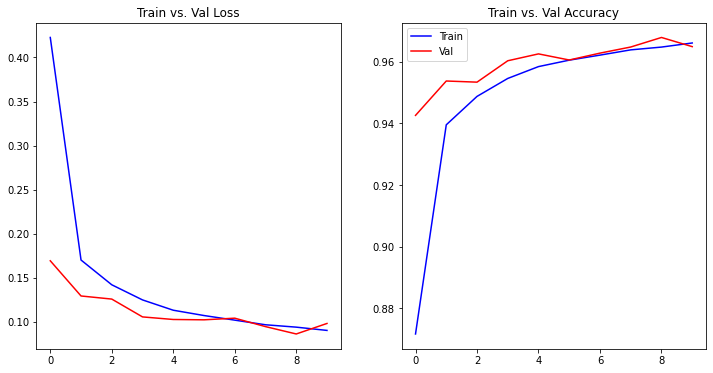

In [ ]:
# display metrics and curves
idx_best_train_loss = np.argmin(train_loss.history)
best_train_loss = train_loss.history[idx_best_train_loss]
idx_best_train_accuracy = np.argmax(train_accuracy.history)
best_train_accuracy = train_accuracy.history[idx_best_train_accuracy]
idx_best_val_loss = np.argmin(val_loss.history)
best_val_loss = val_loss.history[idx_best_val_loss]
idx_best_val_accuracy = np.argmax(val_accuracy.history)
best_val_accuracy = val_accuracy.history[idx_best_val_accuracy]
print('Best Scores:')
print(f'train_loss: {best_train_loss:.4f} (ep: {idx_best_train_loss})')
print(f'train_accuracy {best_train_accuracy:3.2%} (ep: {idx_best_train_accuracy})')
print(f'val_loss: {best_val_loss:.4f} (ep: {idx_best_val_loss})')
print(f'val_accuracy: {best_val_accuracy:3.2%} (ep: {idx_best_val_accuracy})')

x_epochs = list(range(n_epochs))
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(x_epochs, train_loss.history, 'b')
ax[0].plot(x_epochs, val_loss.history, 'r')
_ = ax[0].set_title('Train vs. Val Loss')
ax[1].plot(x_epochs, train_accuracy.history, 'b', label='Train')
ax[1].plot(x_epochs, val_accuracy.history, 'r', label='Val')
_ = ax[1].set_title('Train vs. Val Accuracy')
ax[1].legend()

# Results

## Evaluate on testing set

Here we generate a testing dataset to evaluate the performance of our trained model. Note that the testing accuracy is lower than the validation accuracy displayed above. This is because training and validation both use teacher forcing to produce training labels, whereas testing does not.

In [ ]:
n_rows_test = 1000

def test(model, n_rows_test, n_per_row):
  test_dataset = Scatter2DDataset(n_rows_test, n_per_row, n_per_row)
  test_loader = DataLoader(test_dataset, batch_size=batch_size,
    num_workers=n_workers)

  test_accuracy = AverageMeter()
  hull_overlaps = []
  model.eval()
  for bat, (batch_data, batch_labels, batch_lengths) in enumerate(test_loader):
    batch_data = batch_data.to(device)
    batch_labels = batch_labels.to(device)
    batch_lengths = batch_lengths.to(device)

    log_pointer_scores, pointer_argmaxs = model(batch_data, batch_lengths)

    val_loss.update(loss.item(), batch_data.size(0))
    mask = batch_labels != TOKENS['<eos>']
    acc = masked_accuracy(pointer_argmaxs, batch_labels, mask).item()
    test_accuracy.update(acc, mask.int().sum().item())

    for data, length, ptr in zip(batch_data.cpu(), batch_lengths.cpu(),
        pointer_argmaxs.cpu()):
      hull_overlaps.append(calculate_hull_overlap(data, length, ptr))

  print(f'# Test Samples: {n_per_row:3d}\t '
        f'\tAccuracy: {test_accuracy.avg:3.1%} '
        f'\tOverlap: {np.mean(hull_overlaps):3.1%}')

test(model, n_rows_test, 5)
test(model, n_rows_test, 10)
test(model, n_rows_test, 15)
test(model, n_rows_test, 20)
test(model, n_rows_test, 25)
test(model, n_rows_test, 30)
test(model, n_rows_test, 35)
test(model, n_rows_test, 40)
test(model, n_rows_test, 45)
test(model, n_rows_test, 50)

# Test Samples:   5	 	Accuracy: 25.5% 	Overlap: 4.2%
# Test Samples:  10	 	Accuracy: 24.7% 	Overlap: 13.7%
# Test Samples:  15	 	Accuracy: 34.9% 	Overlap: 42.4%
# Test Samples:  20	 	Accuracy: 59.3% 	Overlap: 78.4%
# Test Samples:  25	 	Accuracy: 78.2% 	Overlap: 88.1%
# Test Samples:  30	 	Accuracy: 79.3% 	Overlap: 86.6%
# Test Samples:  35	 	Accuracy: 80.9% 	Overlap: 83.9%
# Test Samples:  40	 	Accuracy: 80.3% 	Overlap: 74.3%
# Test Samples:  45	 	Accuracy: 78.6% 	Overlap: 67.7%
# Test Samples:  50	 	Accuracy: 76.7% 	Overlap: 65.2%


## Display an example prediction

To finish up, we generate and visualize an example convex hull with our model.

In [ ]:
idx = 0
n_per_row = 50

test_dataset = Scatter2DDataset(n_rows_test, n_per_row, n_per_row)
test_loader = DataLoader(test_dataset, batch_size=batch_size,
  num_workers=n_workers)
batch_data, batch_labels, batch_lengths = next(iter(test_loader))

log_pointer_scores, pointer_argmaxs = model(batch_data.to(device),
  batch_lengths.to(device))

pred_hull_idxs = pointer_argmaxs[idx].cpu()
pred_hull_idxs = pred_hull_idxs[pred_hull_idxs > 1] - 2
points = batch_data[idx, 2:batch_lengths[idx], :2]
true_hull_idxs = ConvexHull(points).vertices.tolist()
true_hull_idxs = cyclic_permute(true_hull_idxs, np.argmin(true_hull_idxs))

overlap = calculate_hull_overlap(batch_data[idx].cpu(), batch_lengths[idx].cpu(),
  pointer_argmaxs[idx].cpu())

print(f'Predicted: {pred_hull_idxs.tolist()}')
print(f'True:      {true_hull_idxs}')
print(f'Hull overlap: {overlap:3.2%}')

Predicted: [42, 47, 48, 18, 14, 7, 0, 40, 46, 45]
True:      [0, 1, 4, 20, 42, 47, 48, 18, 14, 7]
Hull overlap: 64.20%


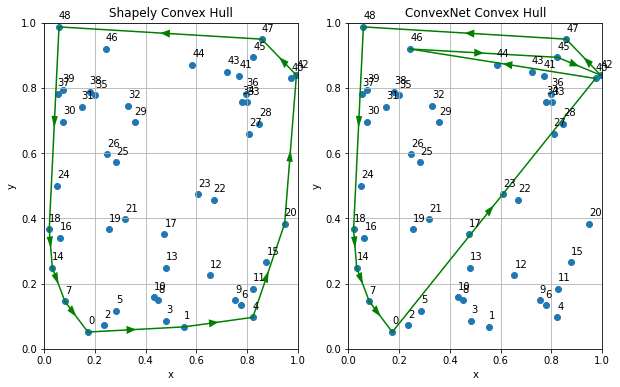

In [ ]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.subplot(1, 2, 1)
true_hull_idxs = ConvexHull(points).vertices.tolist()
display_points_with_hull(points, true_hull_idxs)
_ = plt.title('Shapely Convex Hull')

plt.subplot(1, 2, 2)
display_points_with_hull(points, pred_hull_idxs)
_ = plt.title('ConvexNet Convex Hull')